<a href="https://colab.research.google.com/github/lilyzhizhou/Datathon-5/blob/main/Datathon_5_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import warnings
import torch as t
import torch.nn as nn
import random
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

np.random.seed(42)

In [35]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if t.cuda.is_available()
    else "mps"
    if t.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [36]:
#from google.colab import drive
#drive.mount('/content/drive')

In [37]:
# Load in data
# data = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #5/mhealth.csv')
data = pd.read_csv('mhealth.csv')

# drop subject 9 bc their distribution is different from the others
data = data[data['subject'] != 'subject9']

print(data.shape)
data.head()

(982273, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [38]:
data.dtypes

alx         float64
aly         float64
alz         float64
glx         float64
gly         float64
glz         float64
arx         float64
ary         float64
arz         float64
grx         float64
gry         float64
grz         float64
Activity      int64
subject      object
dtype: object

Split into Training and Testing


---



In [39]:
# Grouping by 'subject' and creating a list of dataframes, one per group
grouped = data.groupby('subject')
grouped_data = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_data, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((753408, 14), (228865, 14))

In [40]:
# train_df.head()
test_df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
161280,0.49965,-9.6680,1.5216,-0.47866,-0.53471,0.53438,-4.6451,-8.2508,1.9208,-0.98039,-0.41889,0.18966,0,subject2
161281,0.40572,-9.5801,1.4001,-0.48423,-0.54409,0.52652,-4.7847,-8.2609,1.9099,-0.98039,-0.41889,0.18966,0,subject2
161282,0.42741,-9.6488,1.4593,-0.48423,-0.54409,0.52652,-4.4974,-8.3198,2.0215,-0.97647,-0.42094,0.20043,0,subject2
161283,0.32193,-9.4522,1.3119,-0.48423,-0.54409,0.52652,-4.6902,-8.4318,1.8180,-0.97647,-0.42094,0.20043,0,subject2
161284,0.46731,-9.6397,1.3769,-0.49165,-0.52345,0.51866,-4.7595,-8.4420,1.7966,-0.97647,-0.42094,0.20043,0,subject2


Normalization

---



In [41]:
# Identifying numerical columns (excluding 'subject' and 'Activity')
numerical_columns = train_df.select_dtypes(include=['float64']).columns.tolist()

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Checking the first few rows of the normalized training data
print(train_df.shape)
train_df.head()

(753408, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,0.214821,-0.022355,0.309939,0.244241,-0.668159,-1.036175,-1.098917,0.233330,-0.594683,-0.335191,-1.016340,-0.471094,0,subject1
1,0.267516,0.023418,0.319902,0.207517,-0.662733,-1.028975,-1.094306,0.278958,-0.636633,-0.335191,-1.016340,-0.471094,0,subject1
2,0.272975,0.009010,0.319384,0.207517,-0.662733,-1.028975,-1.069191,0.286484,-0.572206,-0.335191,-1.016340,-0.471094,0,subject1
3,0.213911,0.042315,0.294847,0.207517,-0.662733,-1.028975,-1.094388,0.279577,-0.548748,-0.349689,-1.012564,-0.486675,0,subject1
4,0.275237,0.052309,0.324983,0.207517,-0.662733,-1.028975,-1.109395,0.309677,-0.538585,-0.349689,-1.012564,-0.486675,0,subject1


Sequence Creation & Addressing Class Imbalance

---



In [42]:
# Sequence creation for data (with undersampling for train data)
sensor_columns = ['alx','aly','alz','glx','gly','glz','arx','ary','arz','grx','gry','grz']

def create_sequences(data, sequence_length=100, train = True):
    sequences = []
    output = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        sequence = data[i:i + sequence_length]
        # We label the sequence with the most intense activity within the sequence
        label = sequence['Activity'].max()

        # Undersampling label 0 for train data only
        if train == False or (label != 0 or random.random() > 0.95): # undersample the 0 labels where there is a 95% chance to drop
          sequences.append(sequence[sensor_columns].values)
          output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df, sequence_length=100, train = True)
X_test, y_test = create_sequences(test_df, sequence_length=100, train = False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2446, 100, 12), (2446,), (2288, 100, 12), (2288,))

<Axes: ylabel='Count'>

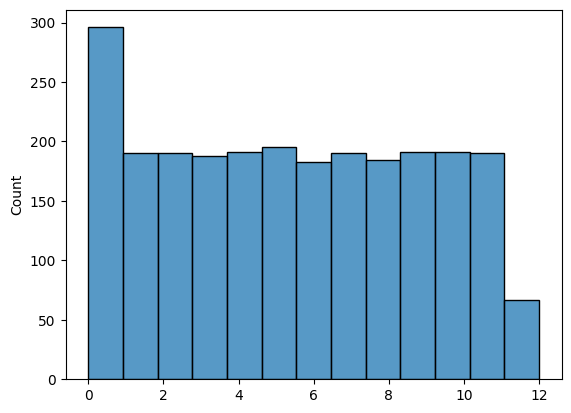

In [43]:
import seaborn as sns
# for i in range(len(y_train)):
#   print(y_train[i])

sns.histplot(y_train)

Training data looks more balanced now

Run LSTM Model

---



In [44]:
class lstmModel(nn.Module): # Model inherits from nn.Module
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True) # LSTM layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out.max(1)[0])
        return nn.functional.log_softmax(out, dim=1)

- will need to tune parameters
- not sure what to set as hidden_size

In [45]:
def modelLoop(epochs, hidden_dim, learning_rate, batch_size):

    # Data preparation
    train_dataset = TensorDataset(t.Tensor(X_train).type(t.float32).to(device), t.Tensor(y_train).type(t.float32).to(device))
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(t.Tensor(X_test).type(t.float32).to(device), t.Tensor(y_test).type(t.float32).to(device))
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = lstmModel(input_size=12, hidden_dim = hidden_dim, num_classes = 13).to(device)

    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store accuracies and losses
    train_accuracy_list = []
    validation_accuracy_list = []
    train_loss_list = []

    # Training loop
    for epoch in range(epochs+1):
        # if epoch % 10 == 0:
        #     learning_rate *= 0.9  # Learning rate scheduling

        per_epoch_loss_list = []

        # Setting Model to train mode
        model.train()

        for X, Y in train_data_loader:
            Y = Y.type(t.LongTensor)   # casting to long
            X = X.type(t.float32)   # casting to long
            X, Y = X.to(device), Y.to(device)
            # Forward pass through layers
            pred = model(X)
            loss = loss_fn(pred, Y)

            per_epoch_loss_list.append(loss.item())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation on training and validation data
        model.eval()
        
        with t.no_grad():
            # Training data
            train_correct, train_total = 0, 0
            for X, Y in train_data_loader:
                y_pred = model(X)
                _, predicted = t.max(y_pred, dim=1)
                train_total += Y.size(0)
                train_correct += (predicted == Y).sum().item()

            train_accuracy = 100 * train_correct / train_total

            # Validation data
            validation_correct, validation_total = 0, 0
            for X, Y in test_data_loader:
                y_pred = model(X)
                _, predicted = t.max(y_pred, dim=1)
                validation_total += Y.size(0)
                validation_correct += (predicted == Y).sum().item()
            validation_accuracy = 100 * validation_correct / validation_total

            # Print accuracy for the current epoch
            # print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')
            if epoch % 10 == 0:
                print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

            # Append accuracy values to lists
            train_accuracy_list.append(train_accuracy)
            validation_accuracy_list.append(validation_accuracy)

            # Calculate and append the average loss for the epoch
            train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    return train_accuracy_list, validation_accuracy_list
    

- Not sure if we want only the last output of the sequence if we initially generated it using the max
(out = out[:, -1, :])

- Using the last observation of sequence: Train Accuracy: 68.8%, Validation Accuracy: 27.4%
- Using max observation of sequence Train Accuracy: 95.8%, Validation Accuracy: 56.4%

In [46]:
    
def plot_acc(train_accuracy_list, validation_accuracy_list):
    # Plot training and validation accuracy over epochs
    plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
    plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
    plt.legend(loc="upper left")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [47]:
# Hyperparameter Tuning
EPOCHS = 100
max_acc = 0

for BATCH_SIZE in [64, 128, 256, 512]:
    for LEARNING_RATE in [0.001, 0.01, 0.1]:
        for HIDDEN_DIM in [16, 32, 64]:
            print(f'Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}, Hidden Dim: {HIDDEN_DIM}')
            train_accuracy_list, validation_accuracy_list = modelLoop(EPOCHS, HIDDEN_DIM, LEARNING_RATE, BATCH_SIZE)
            plot_acc(train_accuracy_list, validation_accuracy_list)
            if validation_accuracy_list[-1] > max_acc:
                max_acc = validation_accuracy_list[-1]
                best_tuning = (BATCH_SIZE, LEARNING_RATE, HIDDEN_DIM)
print(f'Best Batch Size: {best_tuning[0]}, Best Learning Rate: {best_tuning[1]}, Best Hidden Layer Dimension Size(?): {best_tuning[2]}, Resultant Max Accuracy: {max_acc}')

Batch Size: 64, Learning Rate: 0.001, Hidden Dim: 16


RuntimeError: "nll_loss_forward_reduce_cuda_kernel_2d_index" not implemented for 'Float'

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 74.91735537190083%, Validation Accuracy: 46.94055944055944%
Epoch 10/100 ---> Train Accuracy: 97.14876033057851%, Validation Accuracy: 71.06643356643356%
Epoch 20/100 ---> Train Accuracy: 96.5702479338843%, Validation Accuracy: 70.8479020979021%
Epoch 30/100 ---> Train Accuracy: 98.63636363636364%, Validation Accuracy: 71.5472027972028%
Epoch 40/100 ---> Train Accuracy: 98.92561983471074%, Validation Accuracy: 71.41608391608392%
Epoch 50/100 ---> Train Accuracy: 99.29752066115702%, Validation Accuracy: 72.55244755244755%
Epoch 60/100 ---> Train Accuracy: 98.30578512396694%, Validation Accuracy: 63.11188811188811%
Epoch 70/100 ---> Train Accuracy: 97.93388429752066%, Validation Accuracy: 70.8479020979021%
Epoch 80/100 ---> Train Accuracy: 98.59504132231405%, Validation Accuracy: 71.72202797202797%
Epoch 90/100 ---> Train Accuracy: 99.46280991735537%, Validation Accuracy: 72.9895104895105%
Epoch 100/100

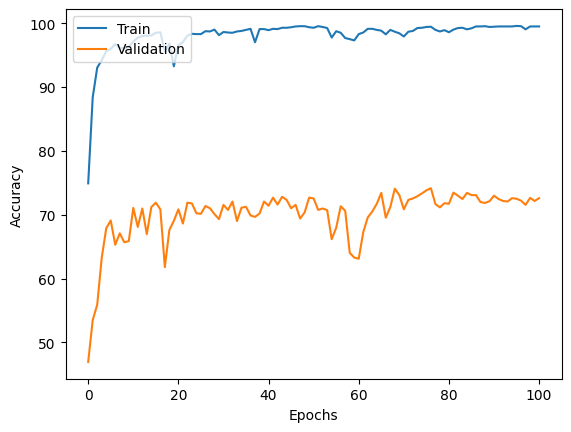

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 128
Epoch 0/100 ---> Train Accuracy: 84.42148760330579%, Validation Accuracy: 41.43356643356643%
Epoch 10/100 ---> Train Accuracy: 97.27272727272727%, Validation Accuracy: 68.0506993006993%
Epoch 20/100 ---> Train Accuracy: 98.47107438016529%, Validation Accuracy: 70.8479020979021%
Epoch 30/100 ---> Train Accuracy: 99.17355371900827%, Validation Accuracy: 72.85839160839161%
Epoch 40/100 ---> Train Accuracy: 94.83471074380165%, Validation Accuracy: 58.74125874125874%
Epoch 50/100 ---> Train Accuracy: 99.25619834710744%, Validation Accuracy: 72.9458041958042%
Epoch 60/100 ---> Train Accuracy: 99.50413223140495%, Validation Accuracy: 72.55244755244755%
Epoch 70/100 ---> Train Accuracy: 99.58677685950413%, Validation Accuracy: 72.85839160839161%
Epoch 80/100 ---> Train Accuracy: 99.62809917355372%, Validation Accuracy: 73.38286713286713%
Epoch 90/100 ---> Train Accuracy: 99.17355371900827%, Validation Accuracy: 69.5367132867133%
Epoch 100/1

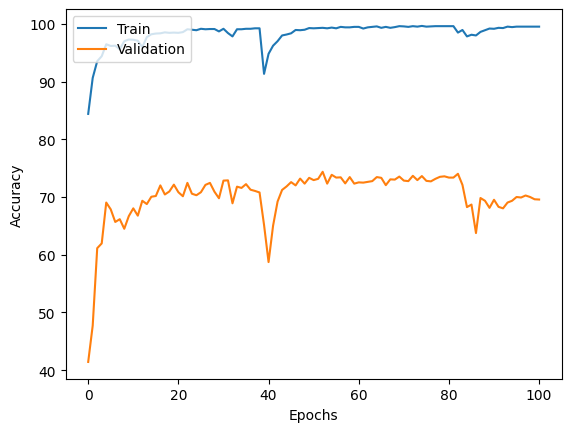

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 256
Epoch 0/100 ---> Train Accuracy: 76.77685950413223%, Validation Accuracy: 34.0472027972028%
Epoch 10/100 ---> Train Accuracy: 98.01652892561984%, Validation Accuracy: 68.40034965034965%
Epoch 20/100 ---> Train Accuracy: 98.96694214876032%, Validation Accuracy: 73.07692307692308%
Epoch 30/100 ---> Train Accuracy: 98.14049586776859%, Validation Accuracy: 70.67307692307692%
Epoch 40/100 ---> Train Accuracy: 97.89256198347107%, Validation Accuracy: 64.5541958041958%
Epoch 50/100 ---> Train Accuracy: 83.18181818181819%, Validation Accuracy: 40.16608391608391%
Epoch 60/100 ---> Train Accuracy: 92.27272727272727%, Validation Accuracy: 55.63811188811189%
Epoch 70/100 ---> Train Accuracy: 96.07438016528926%, Validation Accuracy: 56.33741258741259%
Epoch 80/100 ---> Train Accuracy: 96.52892561983471%, Validation Accuracy: 54.45804195804196%
Epoch 90/100 ---> Train Accuracy: 95.08264462809917%, Validation Accuracy: 56.03146853146853%
Epoch 100

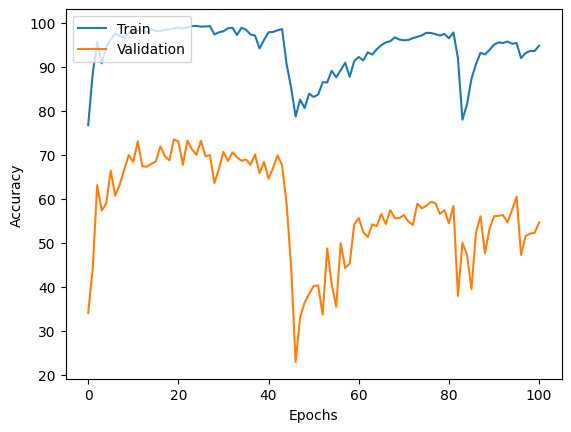

Best Batch Size: 128, Best Learning Rate: 0.01, Best Hidden Layer Dimension Size: 64, Resultant Max Accuracy: 72.59615384615384


In [ ]:
# Hyperparameter Tuning Part 2
EPOCHS = 100
BATCH_SIZE = 128
LEARNING_RATE = 0.01
max_acc = 0

for HIDDEN_DIM in [64, 128, 256]:
    print(f'Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}, Hidden Dim: {HIDDEN_DIM}')
    train_accuracy_list, validation_accuracy_list = modelLoop(EPOCHS, HIDDEN_DIM, LEARNING_RATE, BATCH_SIZE)
    plot_acc(train_accuracy_list, validation_accuracy_list)
    if validation_accuracy_list[-1] > max_acc:
        max_acc = validation_accuracy_list[-1]
        best_tuning = (BATCH_SIZE, LEARNING_RATE, HIDDEN_DIM)
print(f'Best Batch Size: {best_tuning[0]}, Best Learning Rate: {best_tuning[1]}, Best Hidden Layer Dimension Size: {best_tuning[2]}, Resultant Max Accuracy: {max_acc}')